## Program Flow

1. モジュールインポート

# モジュールインポート

In [41]:
# scikitlearnのアルゴリズムのロード
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier 

#import autosklearn.classification

# scikit learnのテストデータの読み込み
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

# scikit learnの精度測定ツールの読み込み
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

#トレーニングデータと正解ラベルに分割
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# pandas(pd) とNumpy(np)のモジュール
import numpy as np
import pandas as pd
import sys,os,random
import warnings
warnings.filterwarnings('ignore')

# 変数定義

In [42]:
# 0.97 は5000万ぐらい儲かった
# pram_traing_rate=0.97   #トレーニングデータとテストデータの比率

pram_traing_rate=0.7  #トレーニングデータとテストデータの比率

# 前処理済みファイルのロード

In [43]:
# 乱数のシード固定
np.random.seed(0)
random.seed(0)
# データフレームの表示件数の設定
pd.set_option('display.max_columns', 100)

# データロード
df = pd.read_csv('data/fx_preprocessing.csv', index_col=None)

y_loc_s=df.columns.get_loc('label_up')
y_loc_e=df.columns.get_loc('label_down')
df.tail(3)


# 前後のデータのカット
df3=df.loc[30:(len(df)-30)]
df2_num=df3.as_matrix()   #numpyへ変換

fx_len=len(df3)

In [44]:

def label_ratio(df_tmp):

    # label数を揃える
    min_labels=[df_tmp[df_tmp['label_up']==1].shape[0],
         df_tmp[df_tmp['label_none']==1].shape[0],
         df_tmp[df_tmp['label_down']==1].shape[0]]

    min_sample=min(min_labels)


    # サンプル後再度結合
    df_tmp=pd.concat([
        df_tmp[df3['label_up']==1].sample(n=min_sample)
        ,df_tmp[df_tmp['label_down']==1].sample(n=min_sample)
        ,df_tmp[df_tmp['label_none']==1].sample(n=min_sample)
        ])

    print(df_tmp[df_tmp['label_up']==1].shape)
    print(df_tmp[df_tmp['label_none']==1].shape)
    print(df_tmp[df_tmp['label_down']==1].shape)
    
    return df_tmp


## データの分割


In [45]:
train, test = train_test_split(df3, train_size=pram_traing_rate,shuffle=False)

print("訓練データ  :{}〜{}".format(train.head(1)['Date'].values[0],train.tail(1)['Date'].values[0]))
print("テストデータ:{}〜{}".format(test.head(1)['Date'].values[0],test.tail(1)['Date'].values[0]))

訓練データ  :2000-10-09〜2013-11-11
テストデータ:2013-11-12〜2019-07-22


In [46]:
# labelの数を整える
train=label_ratio(train)

#トレーニングデータと正解ラベルに分割
trainX,testX=train.iloc[:,3:y_loc_s],test.iloc[:,3:y_loc_s]
trainY,testY=train.iloc[:,y_loc_s:y_loc_e+1],test.iloc[:,y_loc_s:y_loc_e+1]


#Numpy形式に変換
trainX,testX=trainX.as_matrix(),testX.as_matrix()
trainY,testY=trainY.as_matrix(),testY.as_matrix()

#データサンプル数の確認
print("トレーニングデータ",trainX.shape)
print("トレーニングデータ",trainY.shape)
print("　 　 テストデータ",testX.shape)
print("　 　 テストデータ",testY.shape)

(10, 77)
(10, 77)
(10, 77)
トレーニングデータ (30, 63)
トレーニングデータ (30, 3)
　 　 テストデータ (1463, 63)
　 　 テストデータ (1463, 3)


# sckit-learnの準備


In [47]:
# ワンホットからカテゴリ変数へ
testY2 =np.argmax(testY,axis=1)
trainY2=np.argmax(trainY,axis=1)

In [48]:
names = [
         "Random Forest", 
        "Logistic Regression", 
         "SVM",
         "Decision Tree", 
         "Neural Net", 
         "Naive Bayes",
         "AdaBoostClassifier"
        ]

# Initializing Classifiers
classifiers = [
    RandomForestClassifier(random_state=1, n_estimators=100),
    LogisticRegression(),
    SVC(kernel="linear"),
    DecisionTreeClassifier(),
    MLPClassifier(),
    GaussianNB(),
    AdaBoostClassifier()
]

In [49]:
columns=['name','accuracy']
df_acc=pd.DataFrame(data=None,columns=columns)

for classifier, name in zip(classifiers, names):
    
    #　該当分類器にて、学習
    classifier.fit(trainX ,trainY2)
 
    #　分類器の正答率を求める
    pre=classifier.predict(testX)
    ac_score=accuracy_score(testY2,pre)
    print('分類器:{:} , 精度:{:.2%}'.format(name,ac_score))

    # 結果をデータフレームに入れる
    s=pd.Series(data=[name,ac_score],index=columns)
    df_acc=df_acc.append(s,ignore_index=True)

分類器:Random Forest , 精度:34.18%
分類器:Logistic Regression , 精度:32.40%
分類器:SVM , 精度:30.83%
分類器:Decision Tree , 精度:32.88%
分類器:Neural Net , 精度:31.10%
分類器:Naive Bayes , 精度:33.36%
分類器:AdaBoostClassifier , 精度:35.06%


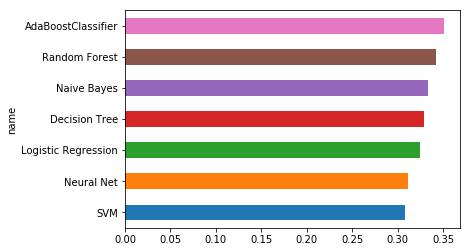

In [50]:
%matplotlib inline
# データフレームの順番を分類器の精度順に表示
df_acc=df_acc.sort_values(by=['accuracy'],ascending=True)
# データフレームのラッパAPIからmatplotのapiをコールして、グラフを作成
df_acc.plot.barh(x='name',y='accuracy',legend=False)

In [51]:
classifier=classifiers[
df_acc[df_acc['accuracy']==df_acc['accuracy'].max()].index[0]
]
classifier.fit(trainX ,trainY2)
 

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

# confusion_matrix

In [52]:
from sklearn import metrics
print("0.label_up  ",test[test['label_up']==1].shape[0])
print("1.label_none",test[test['label_none']==1].shape[0])
print("2.label_down",test[test['label_down']==1].shape[0])

predict_y=classifier.predict(testX)
print("confusion matrix:")
print(metrics.confusion_matrix( testY2,predict_y))
print()
print("classification report:")
target_names = ['up','none','down']
print(metrics.classification_report(testY2,predict_y))

0.label_up   524
1.label_none 19
2.label_down 412
confusion matrix:
[[228 183 113]
 [231 206  90]
 [189 144  79]]

classification report:
             precision    recall  f1-score   support

          0       0.35      0.44      0.39       524
          1       0.39      0.39      0.39       527
          2       0.28      0.19      0.23       412

avg / total       0.34      0.35      0.34      1463



# シミュレーション

In [53]:
close_index=df.columns.get_loc('Close')
open_index=df.columns.get_loc('Open')
date_index=df.columns.get_loc('Date')

MONEY=1000000
LEN=len(df2_num)

start=len(df2_num)-len(testX)
end=len(df2_num)-1
print("start:",df2_num[start,0],"〜end:",df2_num[end,0])

standard=1000000/df2_num[start,1]  
DATE=""
result_out=""
df_sim = pd.DataFrame( columns=['Date', 'Open', 'Close', 'Up', 'money','基準価格','result','predict','正誤','利益率'] )

start: 2013-11-12 〜end: 2019-07-22


In [54]:
for i in range(start,end): 
        PRE=df2_num[i,np.array([
                               3,4,5,
                               6,7,8,
                               9,10,11,
                               12,13,14,
                               15,16,17,
                               18,19,20,
                               21,22,23,
                               24,25,26,
                               27,28,29,
                               30,31,32,

                               33,34,35,
                               36,37,38,
                               39,40,41,
                               42,43,44,
                               45,46,47,
                               48,49,50,
                               51,52,53,
                               54,55,56,
                               57,58,59,
                               60,61,62,
                                            63,64,65
                               ])]
        
        #予測のコマンド
        PRE2 = classifier.predict_proba(np.resize(PRE,(1,trainX.shape[1])))
        PRE2=PRE2[0]
        
        profit_rate=0
        DATE2=df2_num[i,date_index]
        if DATE != DATE2[:7]:       #月初の定点観測
            DATE=DATE2[:7]
            print()
            result_out=result_out+"\n"
            if DATE2[5:7]=="01":
                print("--------------------------------------------------------------------")
                result_out=result_out+"--------------------------------------------------------------------"+"\n"
            STRING=df2_num[i,0]+":資金"+"{:,}".format(int(MONEY))+"(基準"+"{:,}".format(int(standard*df2_num[i,1])).strip()+")"
            print(STRING.strip(),end="")
            result_out=result_out+STRING.strip()+"\n"



        PREDICT    ="None"
        #  売り予測の場合
        if PRE2[2]>0.5:
            PREDICT="sell"
            #print("売:",end=" ")
            profit_rate=df2_num[i,open_index]/df2_num[i, close_index]
            MONEY=(profit_rate)*MONEY

        #  買い予測の場合
        if PRE2[0]>0.5:
            PREDICT="buy"
            #print("買",end=" ")
            profit_rate=df2_num[i,close_index]/df2_num[i,open_index]
            MONEY=(profit_rate)*MONEY

        if df2_num[i,63]==1:
            Y_result="buy"
        elif df2_num[i,65]==1:
            Y_result="sell"
        else:
            Y_result="None"
            
        seigo="×"    
        if Y_result==PREDICT:
            seigo="●"
        
        if profit_rate!=0:
            profit_rate=100*(profit_rate-1)
        
        s1 = pd.Series([df2_num[i,0],                 #日付
                        round(df2_num[i,open_index], 2),        #OPEN
                        round(df2_num[i,close_index],2),        #Close
                        round((df2_num[i,close_index]/df2_num[i,open_index]-1)*100,2),  #アップ率
                        round(MONEY),
                        int(standard*df2_num[i,1]),                 #基準価格
                        Y_result,PREDICT,seigo,
                        round(profit_rate,2)],                     #予測
               index=df_sim.columns)
        df_sim=df_sim.append(s1,ignore_index=True)
        


2013-11-12:資金1,000,000(基準1,000,000)
2013-12-02:資金972,062(基準1,042,755)
--------------------------------------------------------------------
2014-01-01:資金1,025,685(基準1,042,734)
2014-02-03:資金1,039,010(基準931,829)
2014-03-03:資金1,038,381(基準969,068)
2014-04-01:資金1,065,683(基準1,019,348)
2014-05-01:資金1,067,942(基準1,015,788)
2014-06-02:資金1,063,836(基準997,293)
2014-07-01:資金1,060,092(基準990,310)
2014-08-01:資金1,041,783(基準1,000,260)
2014-09-01:資金1,041,077(基準1,017,422)
2014-10-01:資金1,047,682(基準1,005,953)
2014-11-03:資金1,118,924(基準1,071,688)
2014-12-01:資金1,176,568(基準1,121,073)
--------------------------------------------------------------------
2015-01-01:資金1,110,440(基準1,079,661)
2015-02-02:資金1,100,047(基準1,064,215)
2015-03-02:資金1,085,259(基準1,062,040)
2015-04-01:資金1,120,980(基準1,039,903)
2015-05-01:資金1,092,245(基準1,037,062)
2015-06-01:資金1,099,619(基準1,059,022)
2015-07-01:資金1,099,884(基準1,046,730)
2015-08-03:資金1,117,306(基準1,017,641)
2015-09-01:資金1,078,268(基準923,919)
2015-10-01:資金1,033,487(基準896,671)
2015-11-02:

In [55]:
df_sim[(
    df_sim['Date'].str.contains('01-01') |
    df_sim['Date'].str.contains('04-01') |
    df_sim['Date'].str.contains('07-01') |
    df_sim['Date'].str.contains('10-01') 
)]

,Date,Open,Close,Up,money,基準価格,result,predict,正誤,利益率
36,2014-01-01,10.00,10.02,0.20,1025686,1042734,None,None,●,0
100,2014-04-01,9.79,9.79,0.06,1066347,1019348,None,buy,×,0.06
165,2014-07-01,9.52,9.52,-0.06,1060093,990310,None,None,●,0
231,2014-10-01,9.71,9.67,-0.49,1047682,1005953,None,None,●,0
297,2015-01-01,10.34,10.37,0.35,1110441,1079661,None,None,●,0
361,2015-04-01,9.90,9.99,0.96,1120981,1039903,None,None,●,0
426,2015-07-01,10.06,10.06,-0.05,1099884,1046730,None,None,●,0
492,2015-10-01,8.64,8.62,-0.28,1036426,896671,None,sell,×,0.28
558,2016-01-01,7.77,7.78,0.12,927156,809454,None,None,●,0
623,2016-04-01,7.62,7.60,-0.24,811754,791032,None,sell,×,0.24


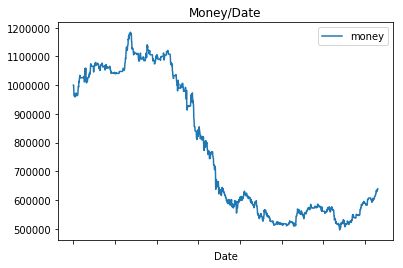

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

df_sim.plot(x='Date',y='money',title='Money/Date')

In [34]:
print("●",df_sim[df_sim['正誤']=="●"].shape)
print("X",df_sim[df_sim['正誤']=="×"].shape)

for i in range(7,19):
    YEAR=str(i+2000)
    start=YEAR+"-01-01"
    end=YEAR+"-12-31"

    tmp=df_sim.query("Date >= @start and Date <= @end ")
    
    print("{:}年の利益率{:.2f}%".format(YEAR,tmp[['利益率']].sum()[0]))

● (604, 10)
X (858, 10)
2007年の利益率0.00%
2008年の利益率0.00%
2009年の利益率0.00%
2010年の利益率0.00%
2011年の利益率0.00%
2012年の利益率0.00%
2013年の利益率2.63%
2014年の利益率8.32%
2015年の利益率-17.37%
2016年の利益率-37.42%
2017年の利益率-9.80%
2018年の利益率-6.00%


# 特徴選択

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

skb=SelectKBest(chi2,k=10)

skb.fit(trainX,trainY2)
trainX_new=skb.transform(trainX)

ValueError: Input X must be non-negative.

In [36]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
model = SVC(kernel='linear', random_state=None)
k_range=np.arange(1,20)
scores=[]
std=[]

#clf = XGBClassifier()
classifier = SVC(kernel='linear', random_state=None)



for k in k_range:
    ss= StratifiedKFold(n_splits  =5,
                       shuffle    =True,
                      random_state=2)
    score=[]
    
    for train_index, val_index in ss.split(trainX,trainY2):
        
        X_train2,X_val =trainX[train_index],trainX[val_index]
        y_train2,y_val =trainY2[train_index],trainY2[val_index]
        
        skb=SelectKBest(chi2,k=k)
        skb.fit(X_train2,y_train2)
        
        X_new_train2=skb.transform(X_train2)
        X_new_val   =skb.transform(X_val)
        
        classifier.fit(X_new_train2,y_train2)
        score.append(clf.score(X_new_val,y_val))
    scores.append(np.array(score).mean())
    std.append(np.array(score).std())

ValueError: Input X must be non-negative.

ValueError: x and y must have same first dimension, but have shapes (19,) and (0,)

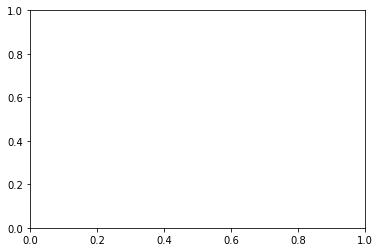

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_range,scores)
plt.errorbar(k_range,scores,yerr=std)
plt.ylabel("accuracy")
plt.xlim(0,20)

# どの説明変数が聞いているのか